In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
#%matplotlib inline
import numpy as np
import wave
import math
import stft
import scipy
import pylab
import pyaudio
from pydub import AudioSegment
import scipy.io.wavfile as wav
import matplotlib.ticker as ticker
from matplotlib import pyplot as plt

## Fourth assignment
### Обработка звука
1. * Создать музыкальный фрагмент, продолжительность – около 30 секунд.
   * В этом фрагменте должна быть какая-то мелодия.
   * Не обязательно очень красивая, но хотя бы такая, чтобы было понятно, что это не случайный набор звуков.
   * Звук генерируется как сумма синусоид на разной частоте и с разной амплитудой.
   * Звук постепенно вступает, а в конце постепенно затухает (т.е. меняется громкость).
2. * Обязательно нужно использовать фрагменты чужих записей (они должны быть прочитаны из файла).
   * Музыкальный фрагмент сохранить в формате wav.
3. * Для итогового фрагмента построить спектрограмму.
4. * В отчете прокомментировать полученную спектрограмму.
   * Загрузить отчёт в формате pdf и музыкальный фрагмент в формате wav.

Создание музыкального фрагмента. Генерация звука

In [3]:
SAMPLE_RATE = 44100  # частота дискретизации
S_16BIT = 2 ** 16    # 16-ти битный звук


def generate_sample(freq, duration, volume):
    """ Функция генерации звука любой частоты, длительности и громкости """
    # амплитуда
    amplitude = np.round(S_16BIT * volume)
    # длительность генерируемого звука в сэмплах
    total_samples = np.round(SAMPLE_RATE * duration)
    # частота дискретизации (пересчитанная)
    w = 2.0 * np.pi * freq / SAMPLE_RATE
    # массив сэмплов
    k = np.arange(0, total_samples)
    # массив значений функции (с округлением)
    return np.round(amplitude * np.sin(k * w))

Генерация звука нот

In [4]:
# Первая октава: частоты нот

#                      до      ре      ми     фа       соль    ля      си    тишина
freq_array = np.array([261.63, 293.66, 329.63, 349.23, 392.00, 440.00, 493.88, 0])

#freq_array=np.array([261.63,277.18,293.66,311.13,329.63,349.23,
#                     369.99,392,415.3,440,466.16,493.88,0])
#freq_array /= 2


def generate_tones(duration):
    """ Генерация нот """
    tones = []
    for freq in freq_array:
        # np.array нужен для преобразования данных под формат 16 бит
        tone = np.array(generate_sample(freq, duration, 1), dtype=np.int16)
        tones.append(tone)
    return tones

Сохранение звуков в файл

In [5]:
tones = generate_tones(1)

notes = [6,5,4,6,5,4,6,7,4,3,2,4,3,2,4,7]
notes += [2,1,3,2,5,4,6,7,5,4,3,1,2,1,0,7,5,3,4,2,3,1,2,7,
          4,2,3,1,2,1,0,7,2,1,3,2,5,4,6,7,5,4,3,1,2,1,0,7]

# Создание мелодии
melody = [tones[i] for i in notes]


def save_wav_file(filename, data):
    """ Сохранение в файл """
    m = wave.open(filename, "wb")
    m.setnchannels(2)
    m.setsampwidth(2)
    m.setframerate(SAMPLE_RATE)
    m.writeframes(b''.join(data))
    m.close()


#save_wav_file("sample1.wav", melody)

In [6]:
pyaudio.get_sample_size(pyaudio.paInt16)

2

Музыкальный фрагмент извне: объединение со сгенерированным

In [7]:
melody = AudioSegment.from_wav("sample1.wav")
other = AudioSegment.from_mp3("a-forest.mp3")

mix = melody.overlay(other)

new = mix.fade_in(4000).fade_out(4000)

#new.export("sample2.wav", format="wav");

Спектрограммы

1. Рисуем волну .wav-файла

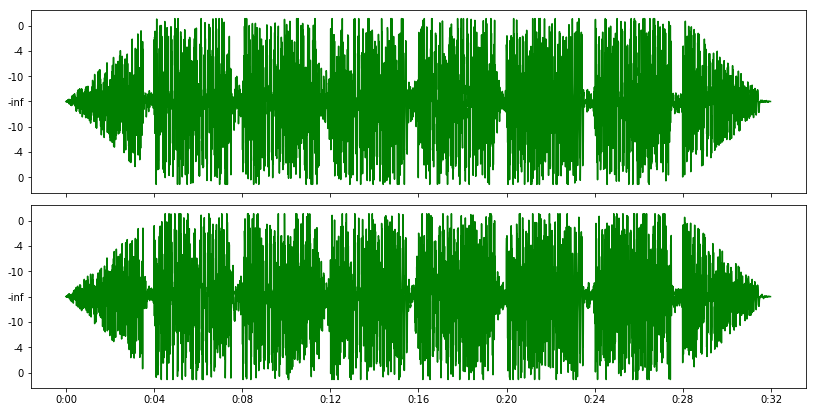

In [8]:
def format_time(x, pos=None):
    global duration, nframes, k
    progress = int(x / float(nframes) * duration * k)
    mins, secs = divmod(progress, 60)
    hours, mins = divmod(mins, 60)
    out = "%d:%02d" % (mins, secs)
    if hours > 0:
        out = "%d:" % hours
    return out


def format_db(x, pos=None):
    if pos == 0:
        return ""
    global peak
    if x == 0:
        return "-inf"
    db = 20 * math.log10(abs(x) / float(peak))
    return int(db)


wav = wave.open("sample2.wav", mode="r")
(nchannels, sampwidth, framerate, nframes, comptype, compname) = wav.getparams()

duration = nframes / framerate  # длительность потока в секундах
w, h = 1000, 500                # ширина и высота выходного изображения
k = round(nframes/w/4)          # коэффициент прореживания канала
DPI = 72                        # произвольное значение, необходимое для перевода пикселей в дюймы
peak = 256 ** sampwidth / 2     # пиковое значение амплитуды сэмпла

content = wav.readframes(nframes)
types = { 1: np.int8, 2: np.int16, 4: np.int32 }
samples = np.fromstring(content, dtype=types[sampwidth])

plt.figure(1, figsize=(float(w)/DPI, float(h)/DPI), dpi=DPI)
plt.subplots_adjust(wspace=0.07, hspace=0.07)

for n in range(nchannels):
    channel = samples[n::nchannels]
    channel = channel[0::k]
    if nchannels == 1:
        channel = channel - peak
    axes = plt.subplot(2, 1, n+1)
    axes.plot(channel, "g")
    axes.yaxis.set_major_formatter(ticker.FuncFormatter(format_db))
    plt.grid(True, color="w")
    axes.xaxis.set_major_formatter(ticker.NullFormatter())

axes.xaxis.set_major_formatter(ticker.FuncFormatter(format_time))
#plt.savefig("wave2", dpi=DPI)
#plt.show()

2. Спектрограмма для итогового фрагмента

In [9]:
def stft(sig, frameSize, overlapFac=0.5, window=np.hanning):
    """ Short time fourier transform of audio signal """
    win = window(frameSize)
    hopSize = int(frameSize - np.floor(overlapFac * frameSize))

    # zeros at beginning (thus center of 1st window should be for sample nr. 0)   
    samples = np.append(np.zeros(int(np.floor(frameSize/2.0))), sig)    
    
    # cols for windowing
    cols = np.ceil( (len(samples) - frameSize) / float(hopSize)) + 1
    
    # zeros at end (thus samples can be fully covered by frames)
    samples = np.append(samples, np.zeros(frameSize))

    frames = np.lib.stride_tricks.as_strided(
        samples, shape=(int(cols), frameSize), strides=(samples.strides[0]*hopSize, samples.strides[0])
    ).copy()
    frames *= win

    return np.fft.rfft(frames)    


def logscale_spec(spec, sr=44100, factor=20.):
    """ Scale frequency axis logarithmically """
    timebins, freqbins = np.shape(spec)
    scale = np.linspace(0, 1, freqbins) ** factor
    scale *= (freqbins-1)/max(scale)
    scale = np.unique(np.round(scale))
    
    # create spectrogram with new freq bins
    newspec = np.complex128(np.zeros([timebins, len(scale)]))
    for i in range(0, len(scale)):        
        if i == len(scale)-1:
            newspec[:,i] = np.sum(spec[:,int(scale[i]):], axis=1)
        else:        
            newspec[:,i] = np.sum(spec[:,int(scale[i]):int(scale[i+1])], axis=1)

    # list center freq of bins
    allfreqs = np.abs(np.fft.fftfreq(freqbins*2, 1./sr)[:freqbins+1])
    freqs = []
    for i in range(0, len(scale)):
        if i == len(scale)-1:
            freqs += [np.mean(allfreqs[int(scale[i]):])]
        else:
            freqs += [np.mean(allfreqs[int(scale[i]):int(scale[i+1])])]

    return newspec, freqs


def plotstft(audiopath, binsize=2**10, plotpath=None, colormap="jet"):
    """ Plot spectrogram """
    samplerate, samples = scipy.io.wavfile.read(audiopath)
    s = stft(samples, binsize)
    sshow, freq = logscale_spec(s, factor=1.0, sr=samplerate)
    ims = 20.*np.log10(np.abs(sshow)/10e-6)  # amplitude to decibel
    timebins, freqbins = np.shape(ims)

    plt.figure(figsize=(18, 9))
    #plt.figure(figsize=(8, 4))
    plt.imshow(np.transpose(ims), origin="lower", aspect="auto", cmap=colormap, interpolation="none")
    plt.colorbar()
    plt.xlabel("time (s)")
    plt.ylabel("frequency (hz)")
    plt.xlim([0, timebins-1])
    plt.ylim([0, freqbins])
    xlocs = np.float32(np.linspace(0, timebins-1, 5))
    plt.xticks(xlocs, ["%.02f" % l for l in ((xlocs*len(samples)/timebins)+(0.5*binsize))/samplerate])
    ylocs = np.int16(np.round(np.linspace(0, freqbins-1, 10)))
    plt.yticks(ylocs, ["%.02f" % freq[i] for i in ylocs])

    if plotpath:
        plt.savefig(plotpath, bbox_inches="tight")
    else:
        plt.show()

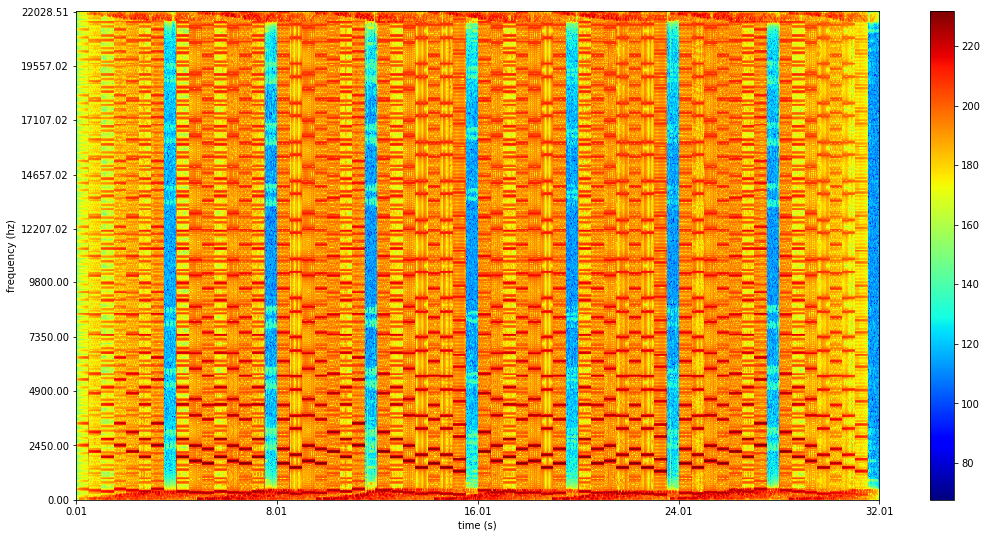

In [10]:
plotstft("sample2.wav")

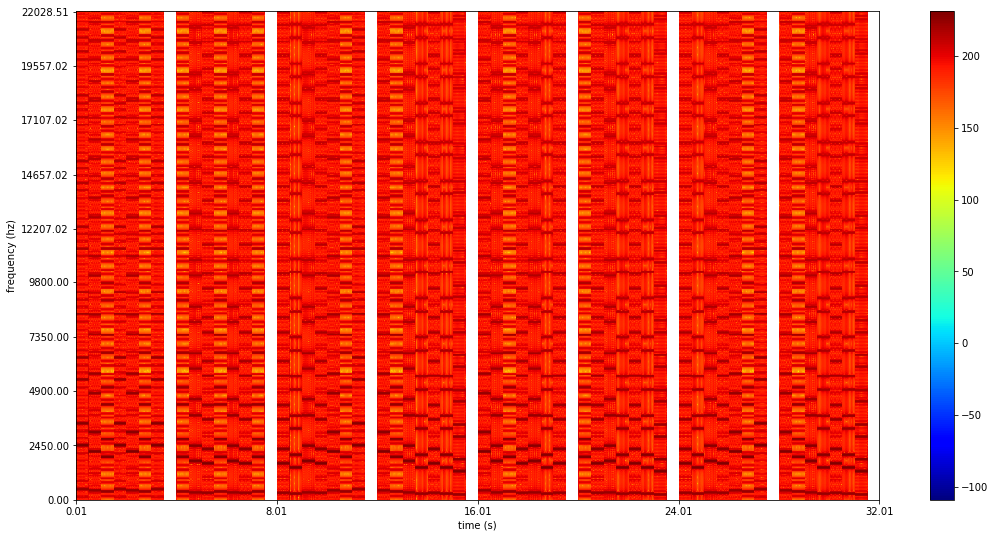

In [11]:
plotstft("sample1.wav")